# Time Series Analysis of Monterey Airport Weather Data

### Contents

1. Setup
2. Linear Regression
3. Exploring Stationarity
4. Autocorrelation

### 1. Setup

In [123]:
from datetime import date
from random import seed, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [124]:
# pandas settings
pd.options.mode.chained_assignment = None  # turn off false positive warnings for editing a copy

In [125]:
df = pd.read_csv('cleaned_df.csv', parse_dates=['datetime'], index_col=['datetime'])
df.head()

,DATE,HourlyPresentWeatherType,HourlySkyConditions,HourlyVisibility,HourlyDryBulbTemperature,HourlyWindSpeed,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindSpeed,DailyPrecipitation,HourlyRelativeHumidity,averageObscuration
datetime,,,,,,,,,,,,
2009-04-01 00:08:00,2009-04-01T00:08:00,NaN,"[{'BKN': SkyCondition(obscuration=7, vertical_...",10.0,52.0,8.0,59.0,49.0,26.0,0.0,77.0,7.0
2009-04-01 00:50:00,2009-04-01T00:50:00,NaN,"[{'SCT': SkyCondition(obscuration=4, vertical_...",9.0,52.0,10.0,59.0,49.0,26.0,0.0,77.0,4.0
2009-04-01 00:54:00,2009-04-01T00:54:00,NaN,"[{'SCT': SkyCondition(obscuration=4, vertical_...",9.0,50.0,9.0,59.0,49.0,26.0,0.0,80.0,4.0
2009-04-01 01:54:00,2009-04-01T01:54:00,NaN,[],9.0,51.0,10.0,59.0,49.0,26.0,0.0,77.0,NaN
2009-04-01 02:54:00,2009-04-01T02:54:00,NaN,[],9.0,50.0,16.0,59.0,49.0,26.0,0.0,80.0,NaN


### 2. Exploring Stationarity

We're primarily modeling the daily maximum temperature and daily average obscuration variables.

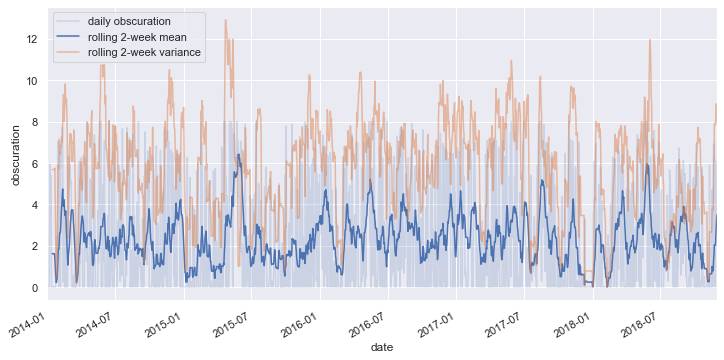

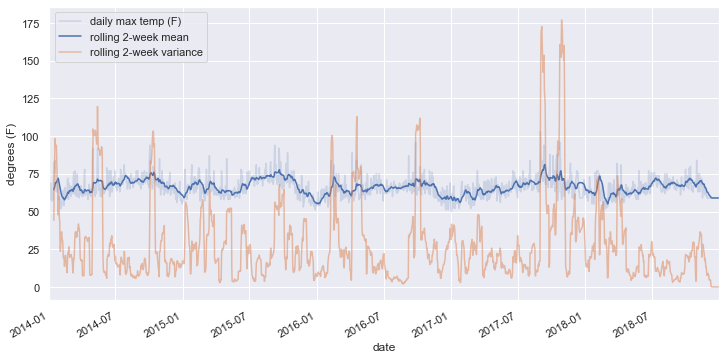

In [182]:
sns.set()

x = df
bool_index = (x.index.hour >= 10) & (x.index.hour <= 16) # consider the clearest and driest part of each day
x = x[bool_index]

obsc = x['averageObscuration'].resample(rule='D').mean().dropna()
temp = x['DailyMaximumDryBulbTemperature'].resample(rule='D').last().dropna()

bool_index = (obsc.index.year >= 2014) & (obsc.index.year <= 2018)
obsc = obsc[bool_index]
bool_index = (temp.index.year >= 2014) & (temp.index.year <= 2018)
temp = temp[bool_index]

plt.figure(figsize=(12, 6))
plt.plot(obsc, color='b', alpha=0.2)
obsc.rolling(14).mean().plot()
obsc.rolling(14).var().plot(alpha=0.5)
plt.xlabel('date')
plt.ylabel('obscuration')
plt.legend(('daily obscuration', 'rolling 2-week mean', 'rolling 2-week variance'))
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(temp, color='b', alpha=0.2)
temp.rolling(14).mean().plot()
temp.rolling(14).var().plot(alpha=0.5)
plt.xlabel('date')
plt.ylabel('degrees (F)')
plt.legend(('daily max temp (F)', 'rolling 2-week mean', 'rolling 2-week variance'))



plt.show()

The series are clearly not stationary: their means and variances are fluctuating all over the place.

Does the Dickey-Fuller test think the daily average obscuration variable acts like a random walk?

In [139]:
results = adfuller(obsc)
print("p-value is:", results[1])

p-value is: 1.472003184704596e-10


We can reject the null hypothesis that the daily average obscuration isn't a random walk. We should proceed with modeling.

How about daily maximum temperature?

In [140]:
results = adfuller(temp)
print("p-value is:", results[1])

p-value is: 1.5908785720630547e-06


We can likewise reject the null hypothesis that the Daily Maximum temperature isn't a random walk.

In [141]:
# sanity check: is a random walk a random walk?

# Generate random residuals
np.random.seed(0)
errors = np.random.normal(0, 1, 1000)

# Create AR(1) (random walk) samples for models with and without unit roots
x_unit_root = [0]
x_no_unit_root = [0]
for i in range(len(errors)):
    x_unit_root.append(x_unit_root[-1] + errors[i])
    x_no_unit_root.append(0.9*x_no_unit_root[-1] + errors[i]) # (0.9 isn't 1, so no unit root)

# Calculate Augmented Dickey-Fuller p-values
adfuller(x_unit_root)[1], adfuller(x_no_unit_root)[1] # everything works as expected

(0.8925193132739655, 3.8562004970537815e-06)

### 3. Autocorrelation

The autocorrelation plots of the two variables' difference series will help suggest the types of models that might be appropriate for forecasting the time series.

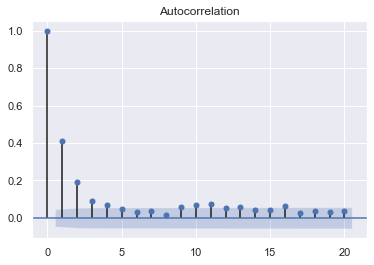

In [192]:
plot_acf(obsc, lags=20)
plt.show()

Lags 1-4 show significant values.

How about the maximum daily temperature series?

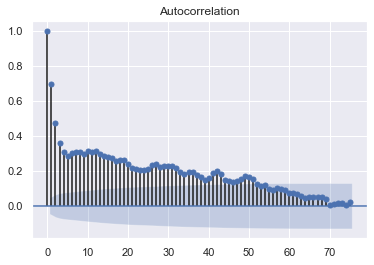

In [198]:
plot_acf(temp, lags=75)
plt.show()

The temperature's autocorrelation plot shows substantial positive and decaying values out to around 70 lags.